In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import PIL
import os
from time import gmtime, strftime
from common import clock, mosaic

In [40]:
def show(img):
    if(len(img.shape)<3):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img))
def show_plt(img):
    if(len(img.shape)<3):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [9]:
data_path = 'data/thresholding/cells/'
dirlist = os.listdir(data_path)
dirlist.sort()
df_imlist = [ a for a in dirlist if 'df' in a ]
# df_imlist.sort()
cl_imlist = [ a for a in dirlist if 'cl' in a ]
print(len(cl_imlist))

pr_imlist = [ a for a in dirlist if 'pr' in a ]
print(len(pr_imlist))

pd.DataFrame([df_imlist, cl_imlist, pr_imlist])

712
712


0                1                2                3    \
0  3884_000_df.jpg  3884_001_df.jpg  3884_002_df.jpg  3884_003_df.jpg   
1  3884_000_cl.jpg  3884_001_cl.jpg  3884_002_cl.jpg  3884_003_cl.jpg   
2  3884_000_pr.jpg  3884_001_pr.jpg  3884_002_pr.jpg  3884_003_pr.jpg   

               4                5                6                7    \
0  3884_004_df.jpg  3884_005_df.jpg  3884_006_df.jpg  3884_007_df.jpg   
1  3884_004_cl.jpg  3884_005_cl.jpg  3884_006_cl.jpg  3884_007_cl.jpg   
2  3884_004_pr.jpg  3884_005_pr.jpg  3884_006_pr.jpg  3884_007_pr.jpg   

               8                9    ...              702              703  \
0  3884_008_df.jpg  3884_009_df.jpg  ...  3990_123_df.jpg  3990_124_df.jpg   
1  3884_008_cl.jpg  3884_009_cl.jpg  ...  3990_123_cl.jpg  3990_124_cl.jpg   
2  3884_008_pr.jpg  3884_009_pr.jpg  ...  3990_123_pr.jpg  3990_124_pr.jpg   

               704              705              706              707  \
0  3990_125_df.jpg  3990_126_df.jpg  3990_127_df.jpg  3990_128_df.jpg   
1  3990_125_cl.jpg  3990_126_cl.jpg  3990_127_cl.jpg  3990_128_cl.jpg   
2  3990_125_pr.jpg  3990_126_pr.jpg  3990_127_pr.jpg  3990_128_pr.jpg   

               708              709              710              711  
0  3990_129_df.jpg  3990_130_df.jpg  3990_131_df.jpg  3990_132_df.jpg  
1  3990_129_cl.jpg  3990_130_cl.jpg  3990_131_cl.jpg  3990_132_cl.jpg  
2  3990_129_pr.jpg  3990_130_pr.jpg  3990_131_pr.jpg  3990_132_pr.jpg  

[3 rows x 712 columns]

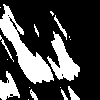

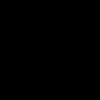

1713549


In [10]:
df = cv2.imread(data_path+df_imlist[0])
ret, th = cv2.threshold(df, 20, 255, cv2.THRESH_BINARY)

show(th)
pr = cv2.imread(data_path+pr_imlist[0])
show(pr)
error = abs(th - pr).sum()
error
minError = float('Inf')
for i in range(256):
    ret, th = cv2.threshold(df, i, 255, cv2.THRESH_BINARY)
    error = abs(th - pr).sum()
    if error < minError:
        minError = error
    else:
        break
cl = cv2.imread(data_path+cl_imlist[0])
illuminationImg = np.amax(cl, axis=2)
# show(illuminationImg)
illumination = illuminationImg.sum()
print(illumination)
# show(cl)

In [13]:
def calc_error(df, pr, threshold):
    pr = pr.astype('int')
    ret, th = cv2.threshold(df, threshold, 255, cv2.THRESH_BINARY)
    th = th.astype('int')
    error = abs(th - pr).sum()
    return error

def find_best_th(df, pr):
    minError = float('Inf')
    threshold = None
    for i in range(256):
        error = calc_error(df, pr, i)
        if error < minError:
            minError = error
            threshold = i
    return threshold, minError

df = cv2.imread(data_path+df_imlist[50])
df = cv2.cvtColor(df, cv2.COLOR_BGR2GRAY)

pr = cv2.imread(data_path+pr_imlist[50], cv2.IMREAD_UNCHANGED)

tresh, error = find_best_th(df, pr)
print('theshold',tresh)
print('===========================')
thresh_num = 65
ret, th_img = cv2.threshold(df, thresh_num, 255, cv2.THRESH_BINARY)


theshold 65


In [14]:
rows_list = []
date = strftime("%Y-%m-%d %H:%M:%S", gmtime())

for j in range(len(df_imlist)):
    sys.stdout.write("\r%f%%" % (j*100/len(df_imlist)))
    sys.stdout.flush()
        
    df = cv2.imread(data_path+df_imlist[j])
    pr = cv2.imread(data_path+pr_imlist[j])
    cl = cv2.imread(data_path+cl_imlist[j])

    threshold, minError = find_best_th(df, pr)
            
    illuminationImg = np.amax(cl, axis=2)
    ill = illuminationImg.sum()
    rows_list.append([df_imlist[j], cl_imlist[j], pr_imlist[j], ill, threshold, minError])

df = pd.DataFrame(rows_list, columns=['diffrence', 'color', 'mask', 'illumination', 'threshold','min_error'])
csvPath = 'sheets/thresholding_dataframe_'+f"{date}"+'.csv'
df.to_csv(csvPath, index=False)

99.859551%

(239, 2)


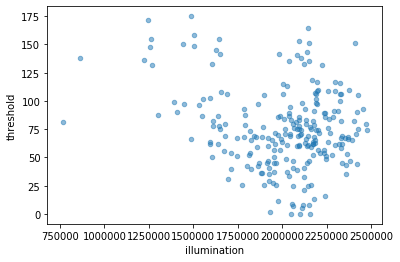

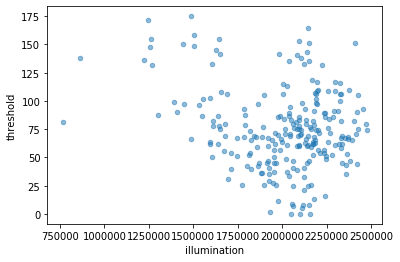

In [15]:
df2 = df[df.min_error > 0]
df2 = df2.loc[:, ['illumination', 'threshold']]
df2.plot.scatter(x='illumination', y= 'threshold',  alpha=0.5)
print(df2.shape)

df3 = df2.groupby('illumination').min()
df3 = df3.reset_index()

df3.plot.scatter(x='illumination', y= 'threshold', alpha=0.5)


In [20]:
def extract_red(img):
    red_channel = img[:,:,2]
    ret, th = cv2.threshold(red_channel, 250, 255, cv2.THRESH_BINARY) 
    return th

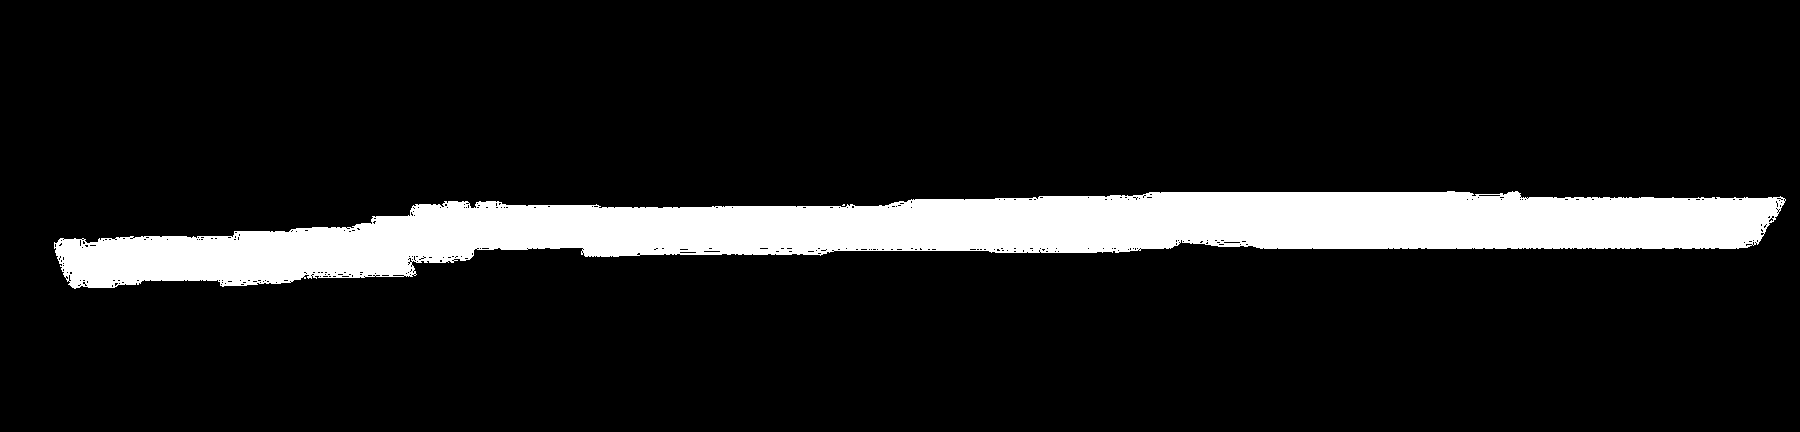

In [22]:
image_num = 3884
original_pr = cv2.imread('data/thresholding/cropped/3884_pr.jpg', cv2.IMREAD_UNCHANGED)
original_pr = extract_red(original_pr)
original_pr_to_show = cv2.cvtColor(original_pr, cv2.COLOR_GRAY2BGR)
show(original_pr_to_show)

(432, 1800)
72


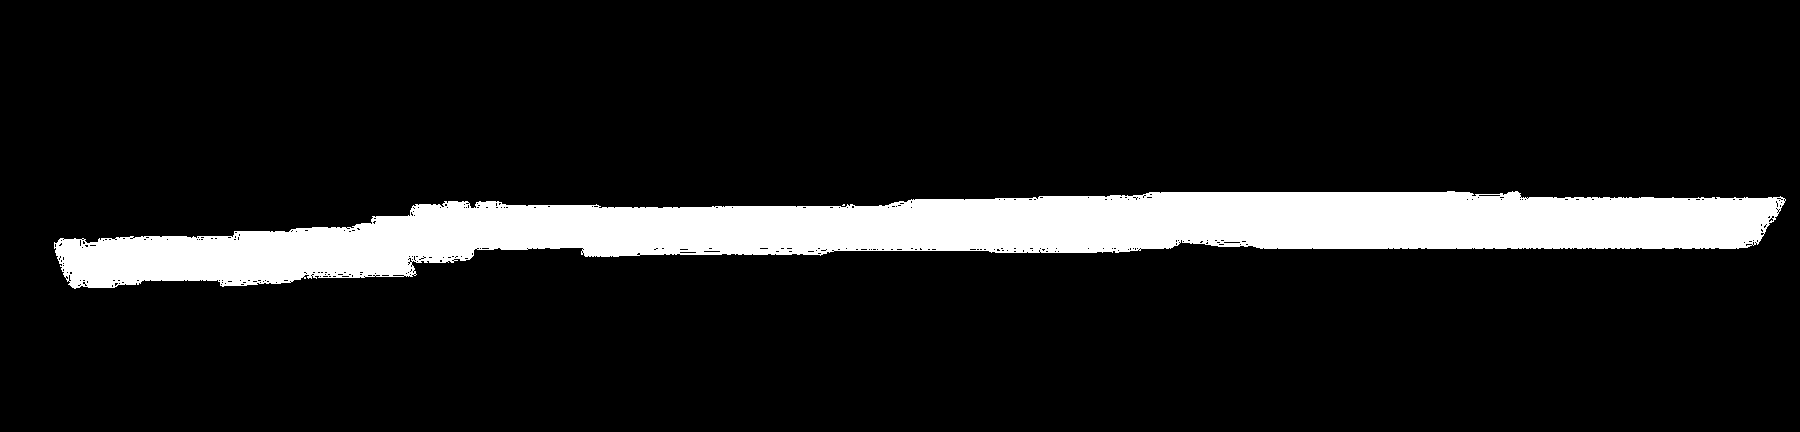

False

In [28]:
original_df = cv2.imread('data/thresholding/cropped/3884_df.jpg')

original_df = cv2.cvtColor(original_df, cv2.COLOR_BGR2GRAY)
print(original_df.shape)
threshold, minError = find_best_th(original_df, original_pr)
print(threshold)
ret, glob_th = cv2.threshold(original_df, threshold, 255, cv2.THRESH_BINARY)
glob_th_to_show = cv2.cvtColor(original_pr, cv2.COLOR_GRAY2BGR)

show(glob_th_to_show)
cv2.imwrite('thresholding_data/big_images/global_thresholding.jpg', glob_th)

In [30]:
cells_file_list_df = [ a for a in df_imlist if str(image_num) in a ]
cells_file_list_pr = [ a for a in pr_imlist if str(image_num) in a ]

cells_list_df = []
for fname in cells_file_list_df:
    cells_list_df.append(cv2.imread(data_path+fname))
    
cells_list_pr = []
for fname in cells_file_list_pr:
    cells_list_pr.append(cv2.imread(data_path+fname, cv2.IMREAD_UNCHANGED))

In [31]:
cells_list_th = []
for i, cell in enumerate(cells_list_df):
    df = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    pr = cells_list_pr[i]
    tresh, error = find_best_th(df, pr)
    ret, th_img = cv2.threshold(df, tresh, 255, cv2.THRESH_BINARY)
    cells_list_th.append(th_img)
    fname = cells_file_list_df[i]
    parts = fname.split('_')[:2]
    name = '_'.join(parts) +'.jpg'
    directory = 'thresholding_data/th_cells/'
    Path(directory).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(directory+name, th_img)


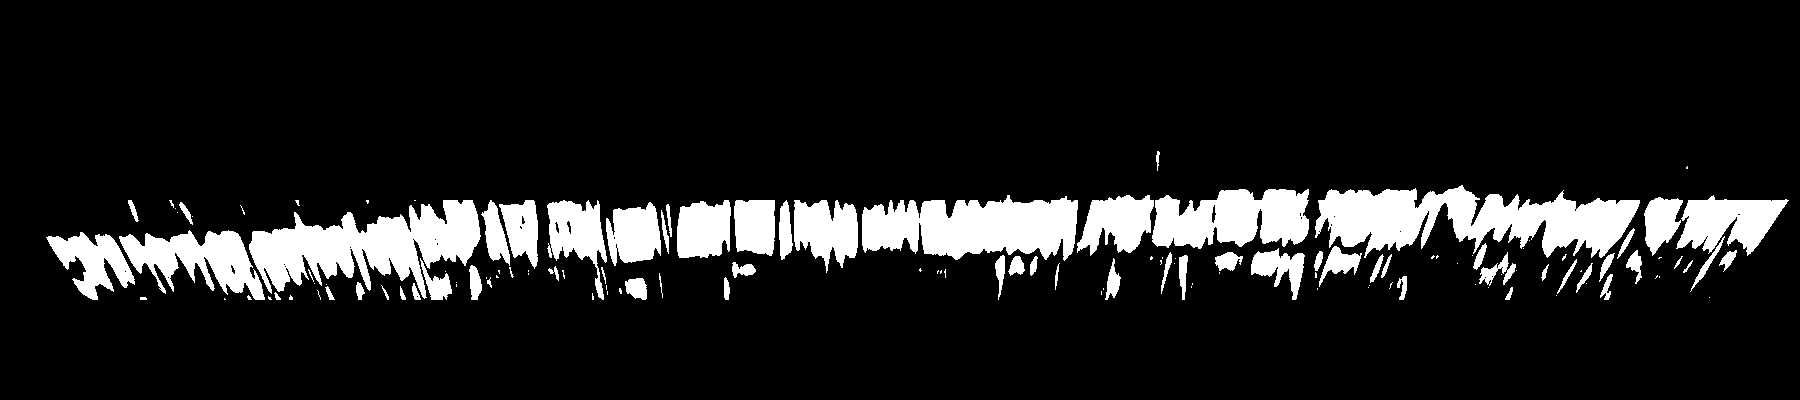

In [35]:
local_th = mosaic(18, cells_list_th)
local_th = cv2.cvtColor(local_th, cv2.COLOR_GRAY2BGR)
show(local_th)

# LIME effect on global threshold

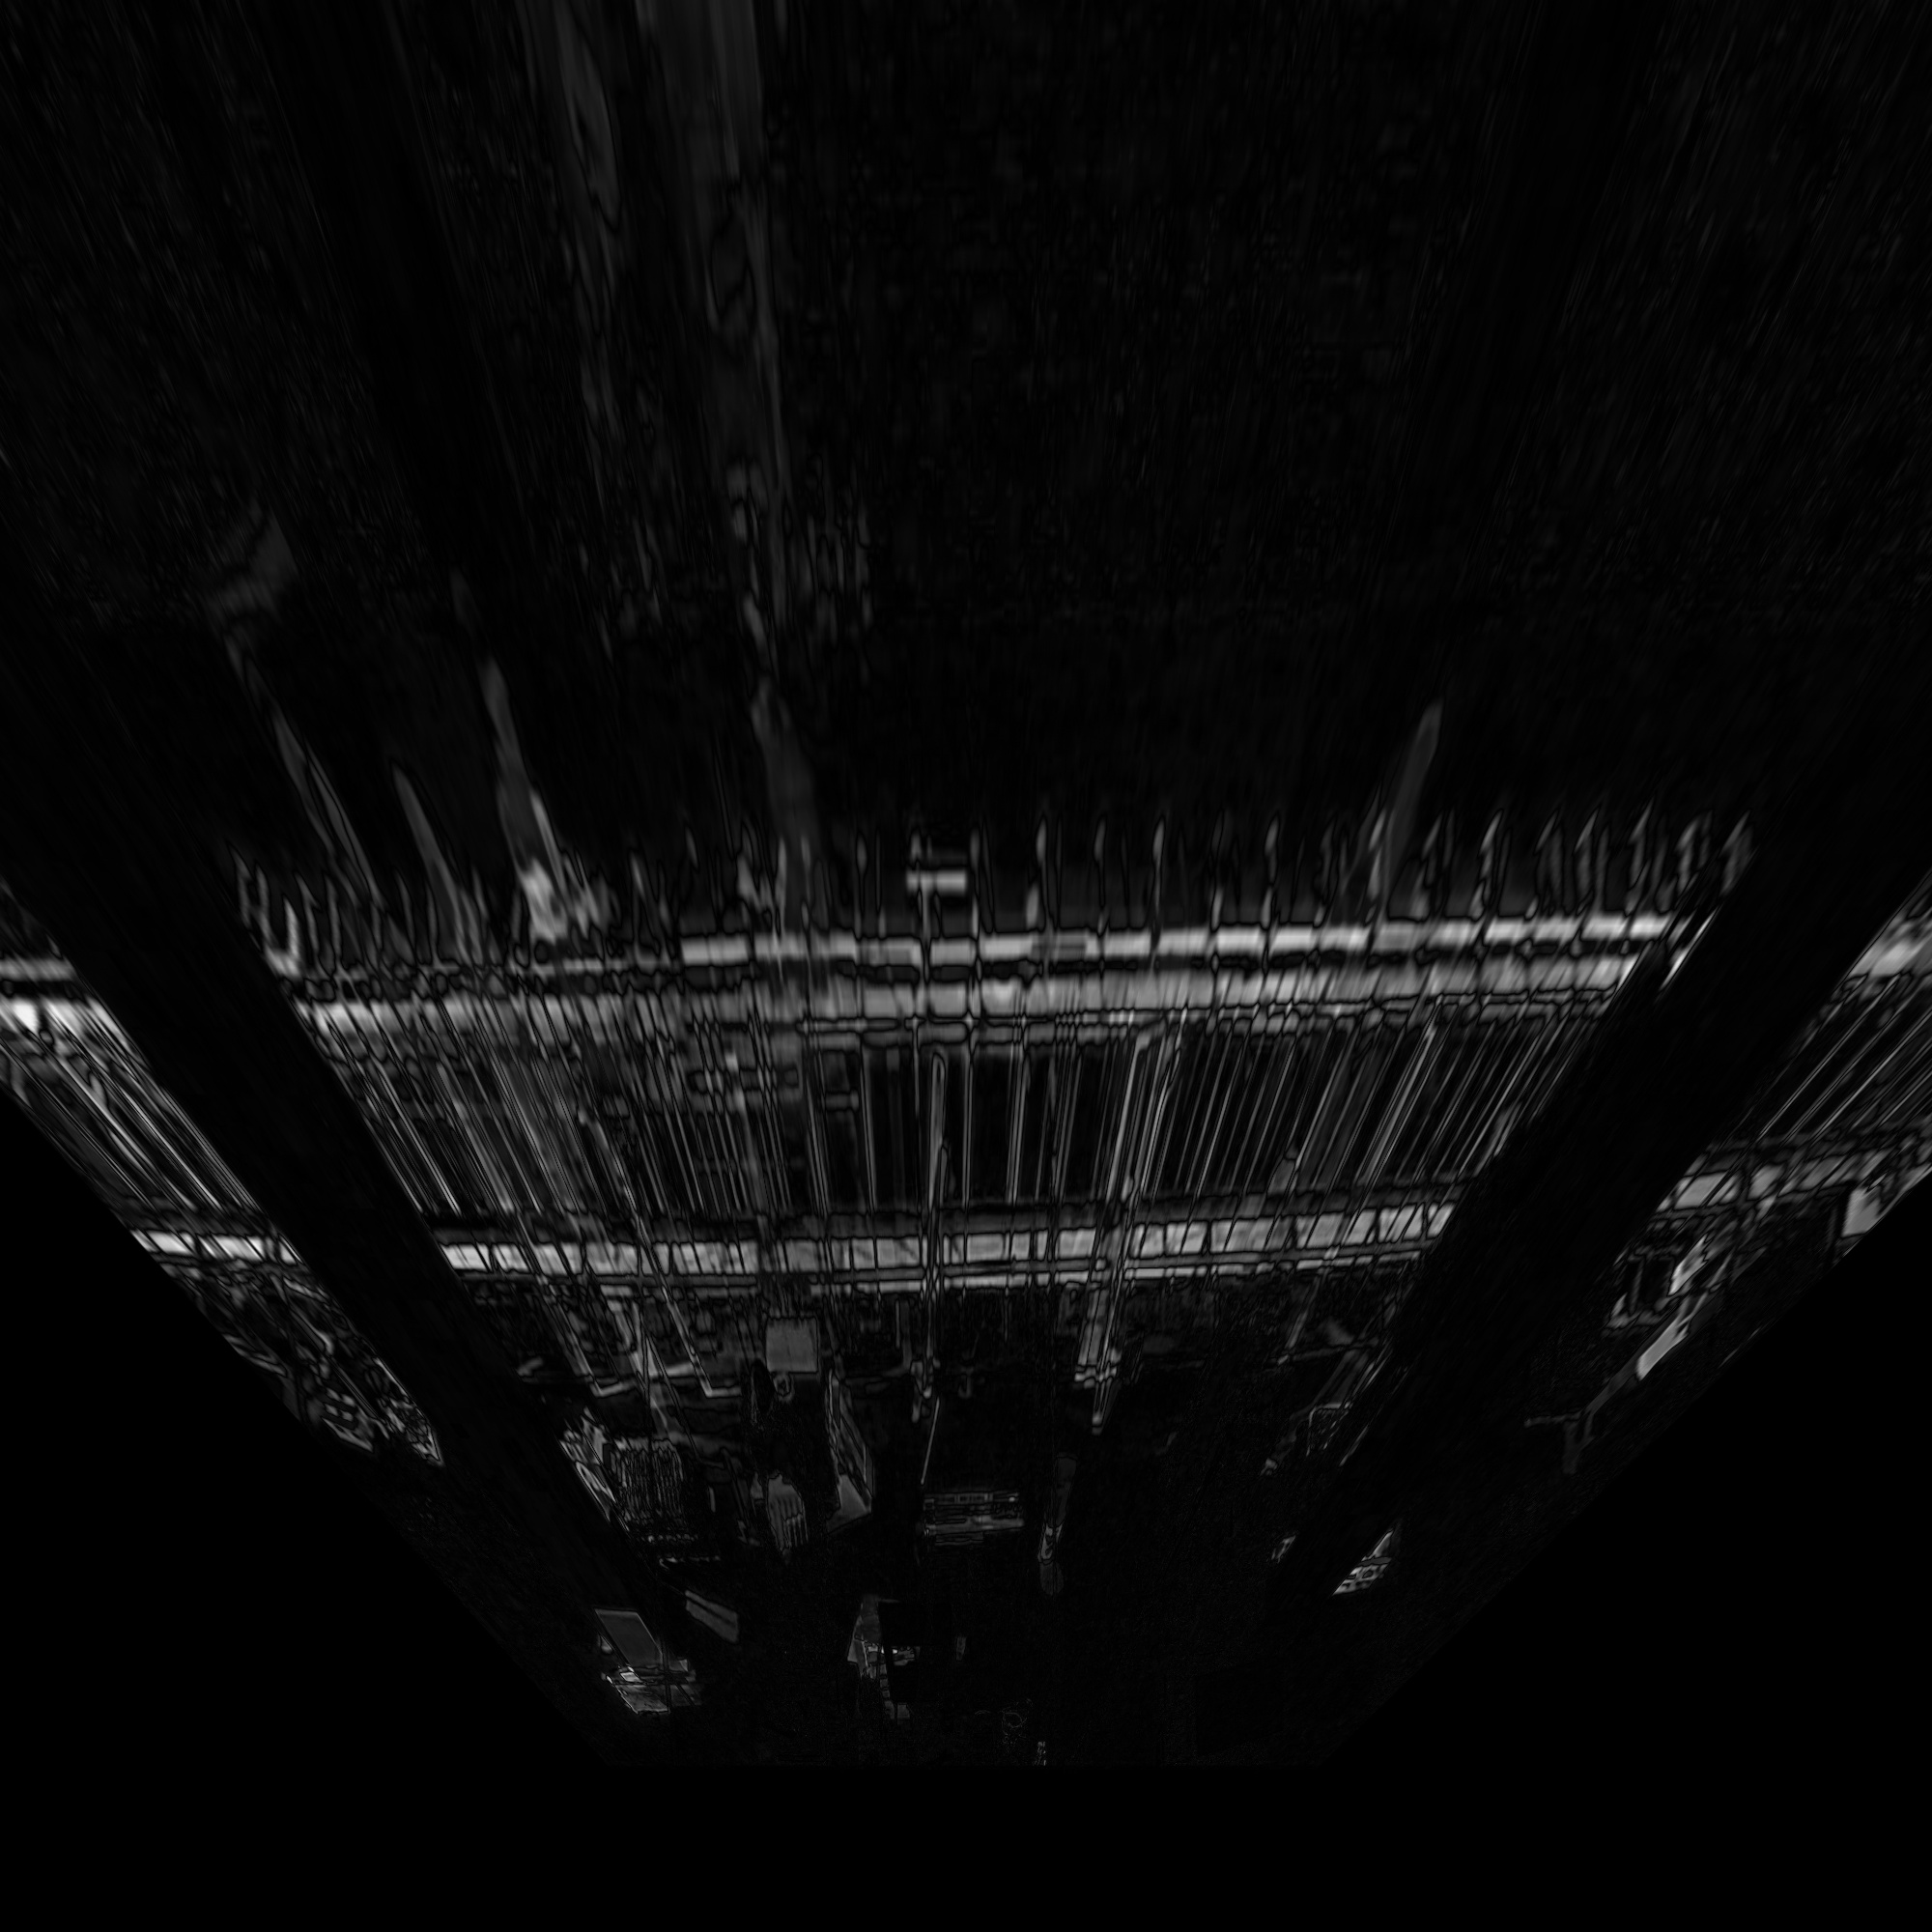

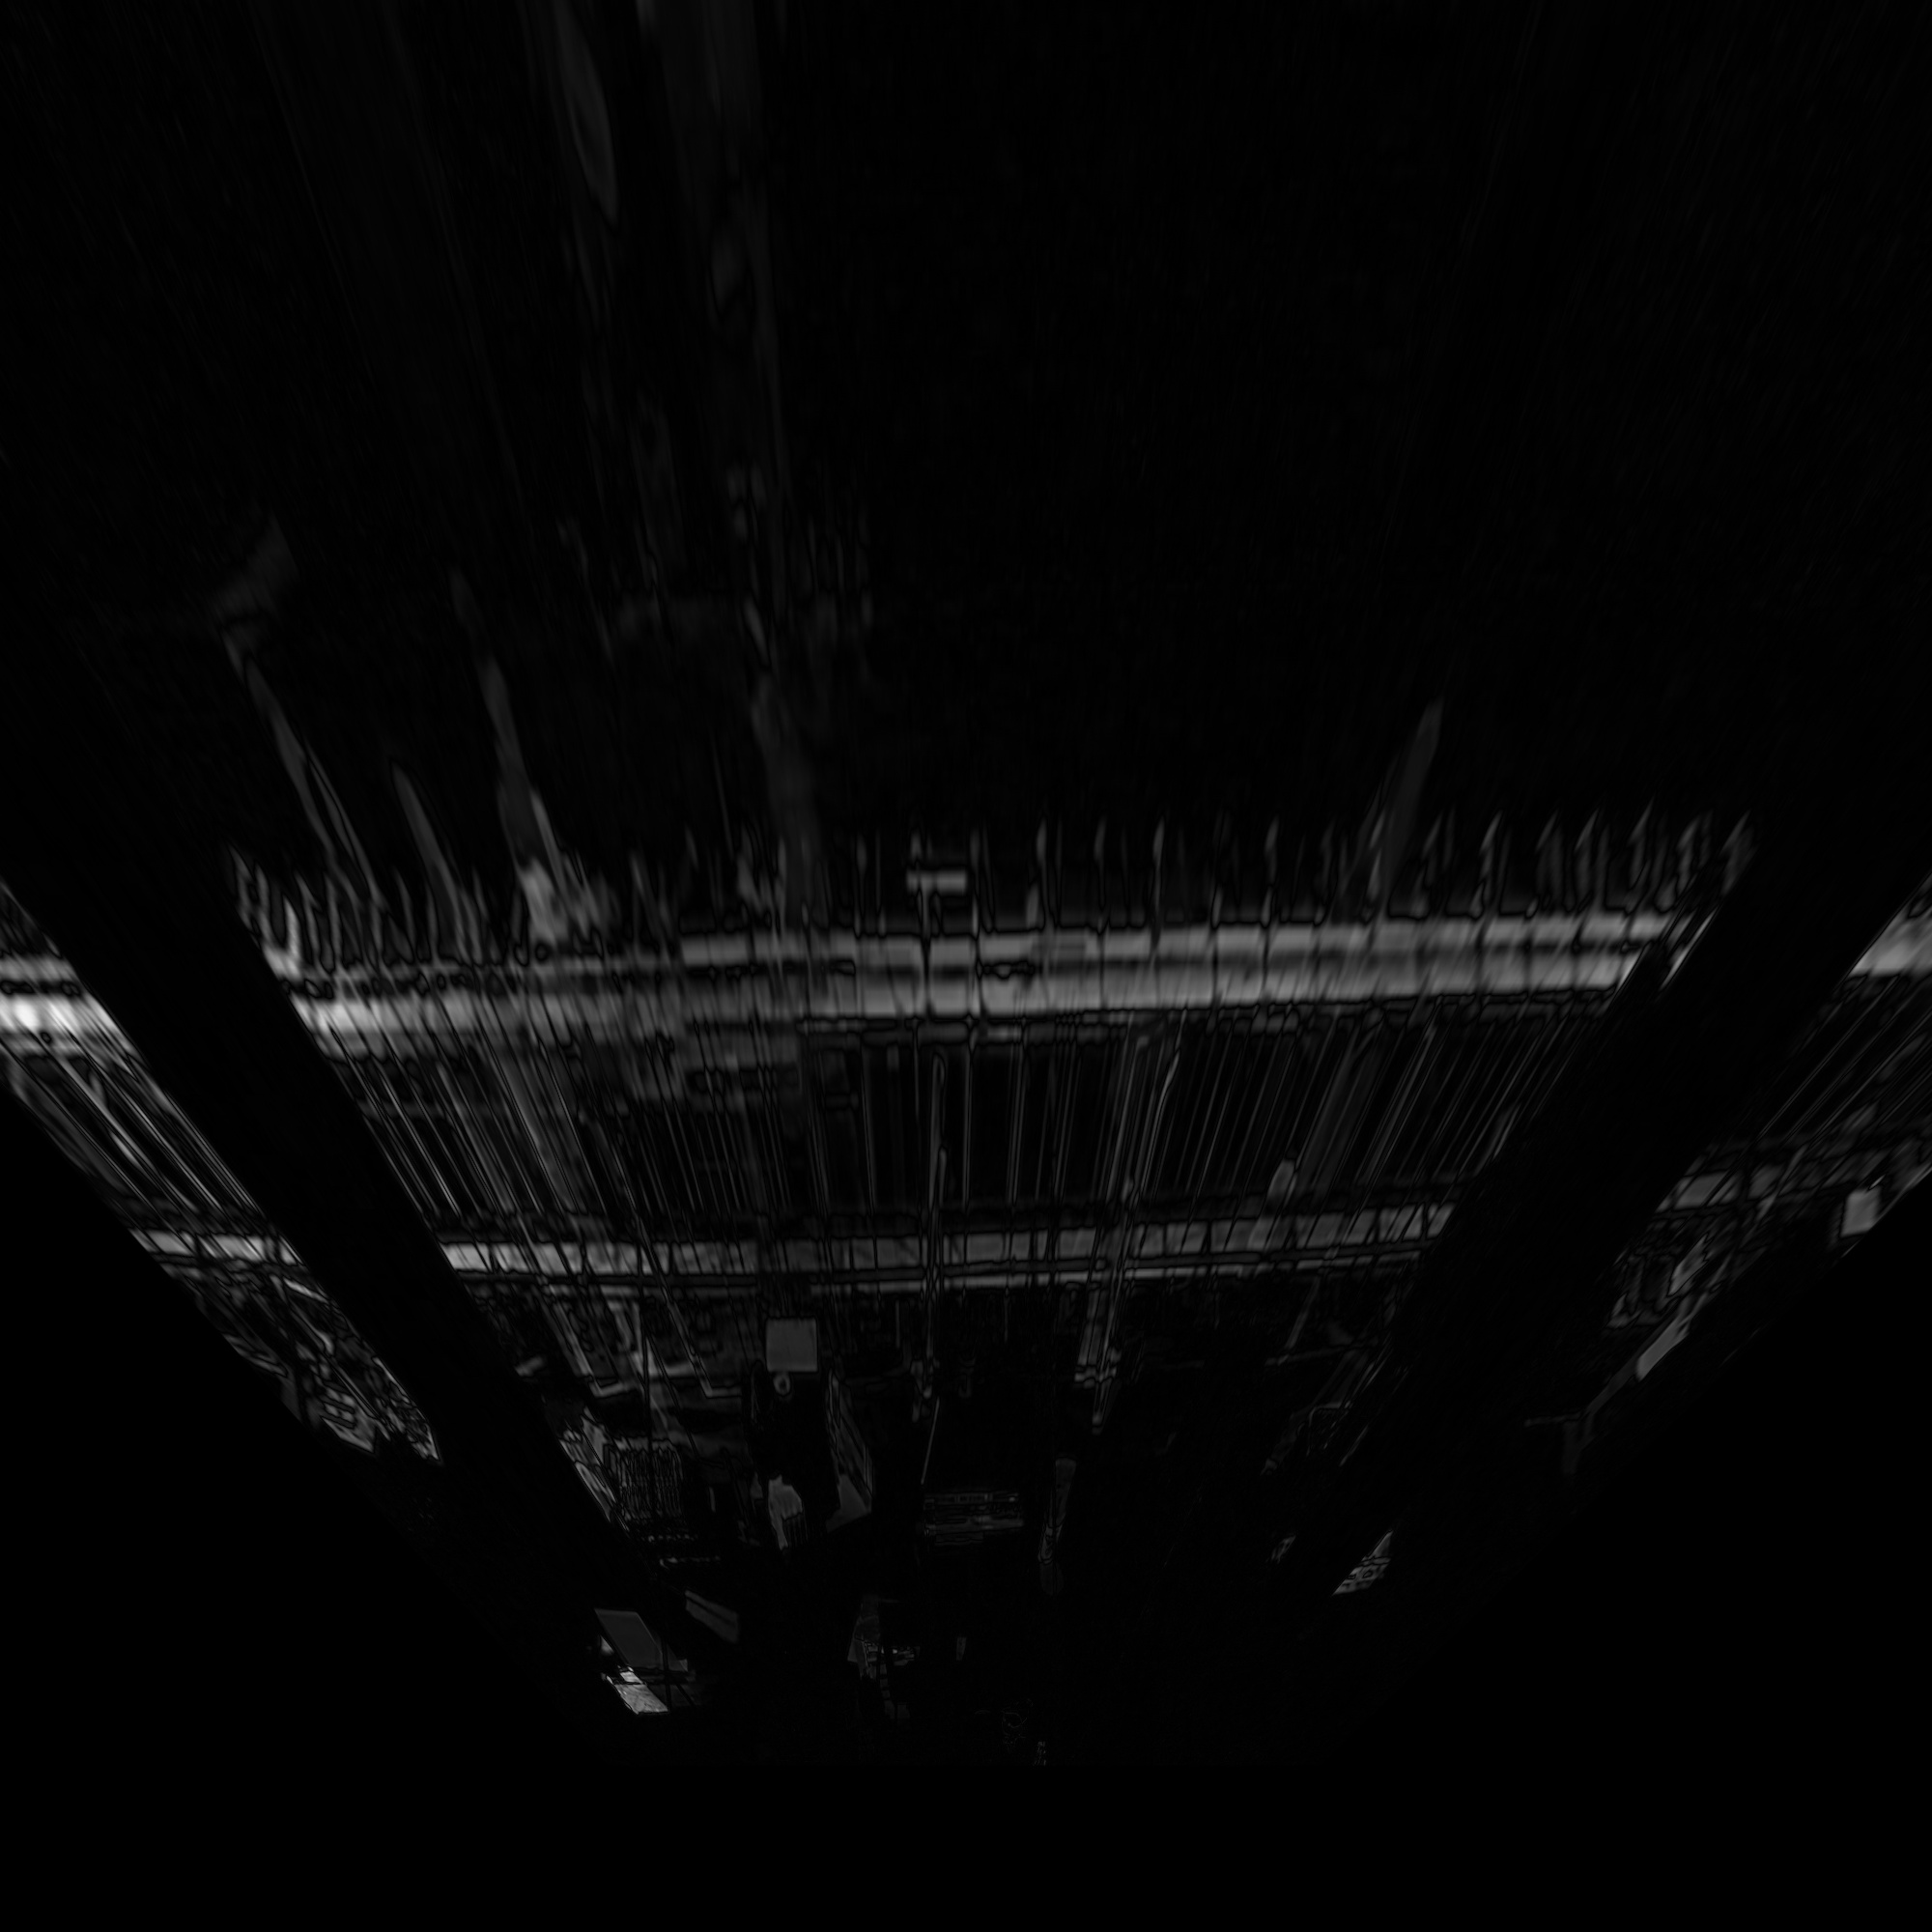

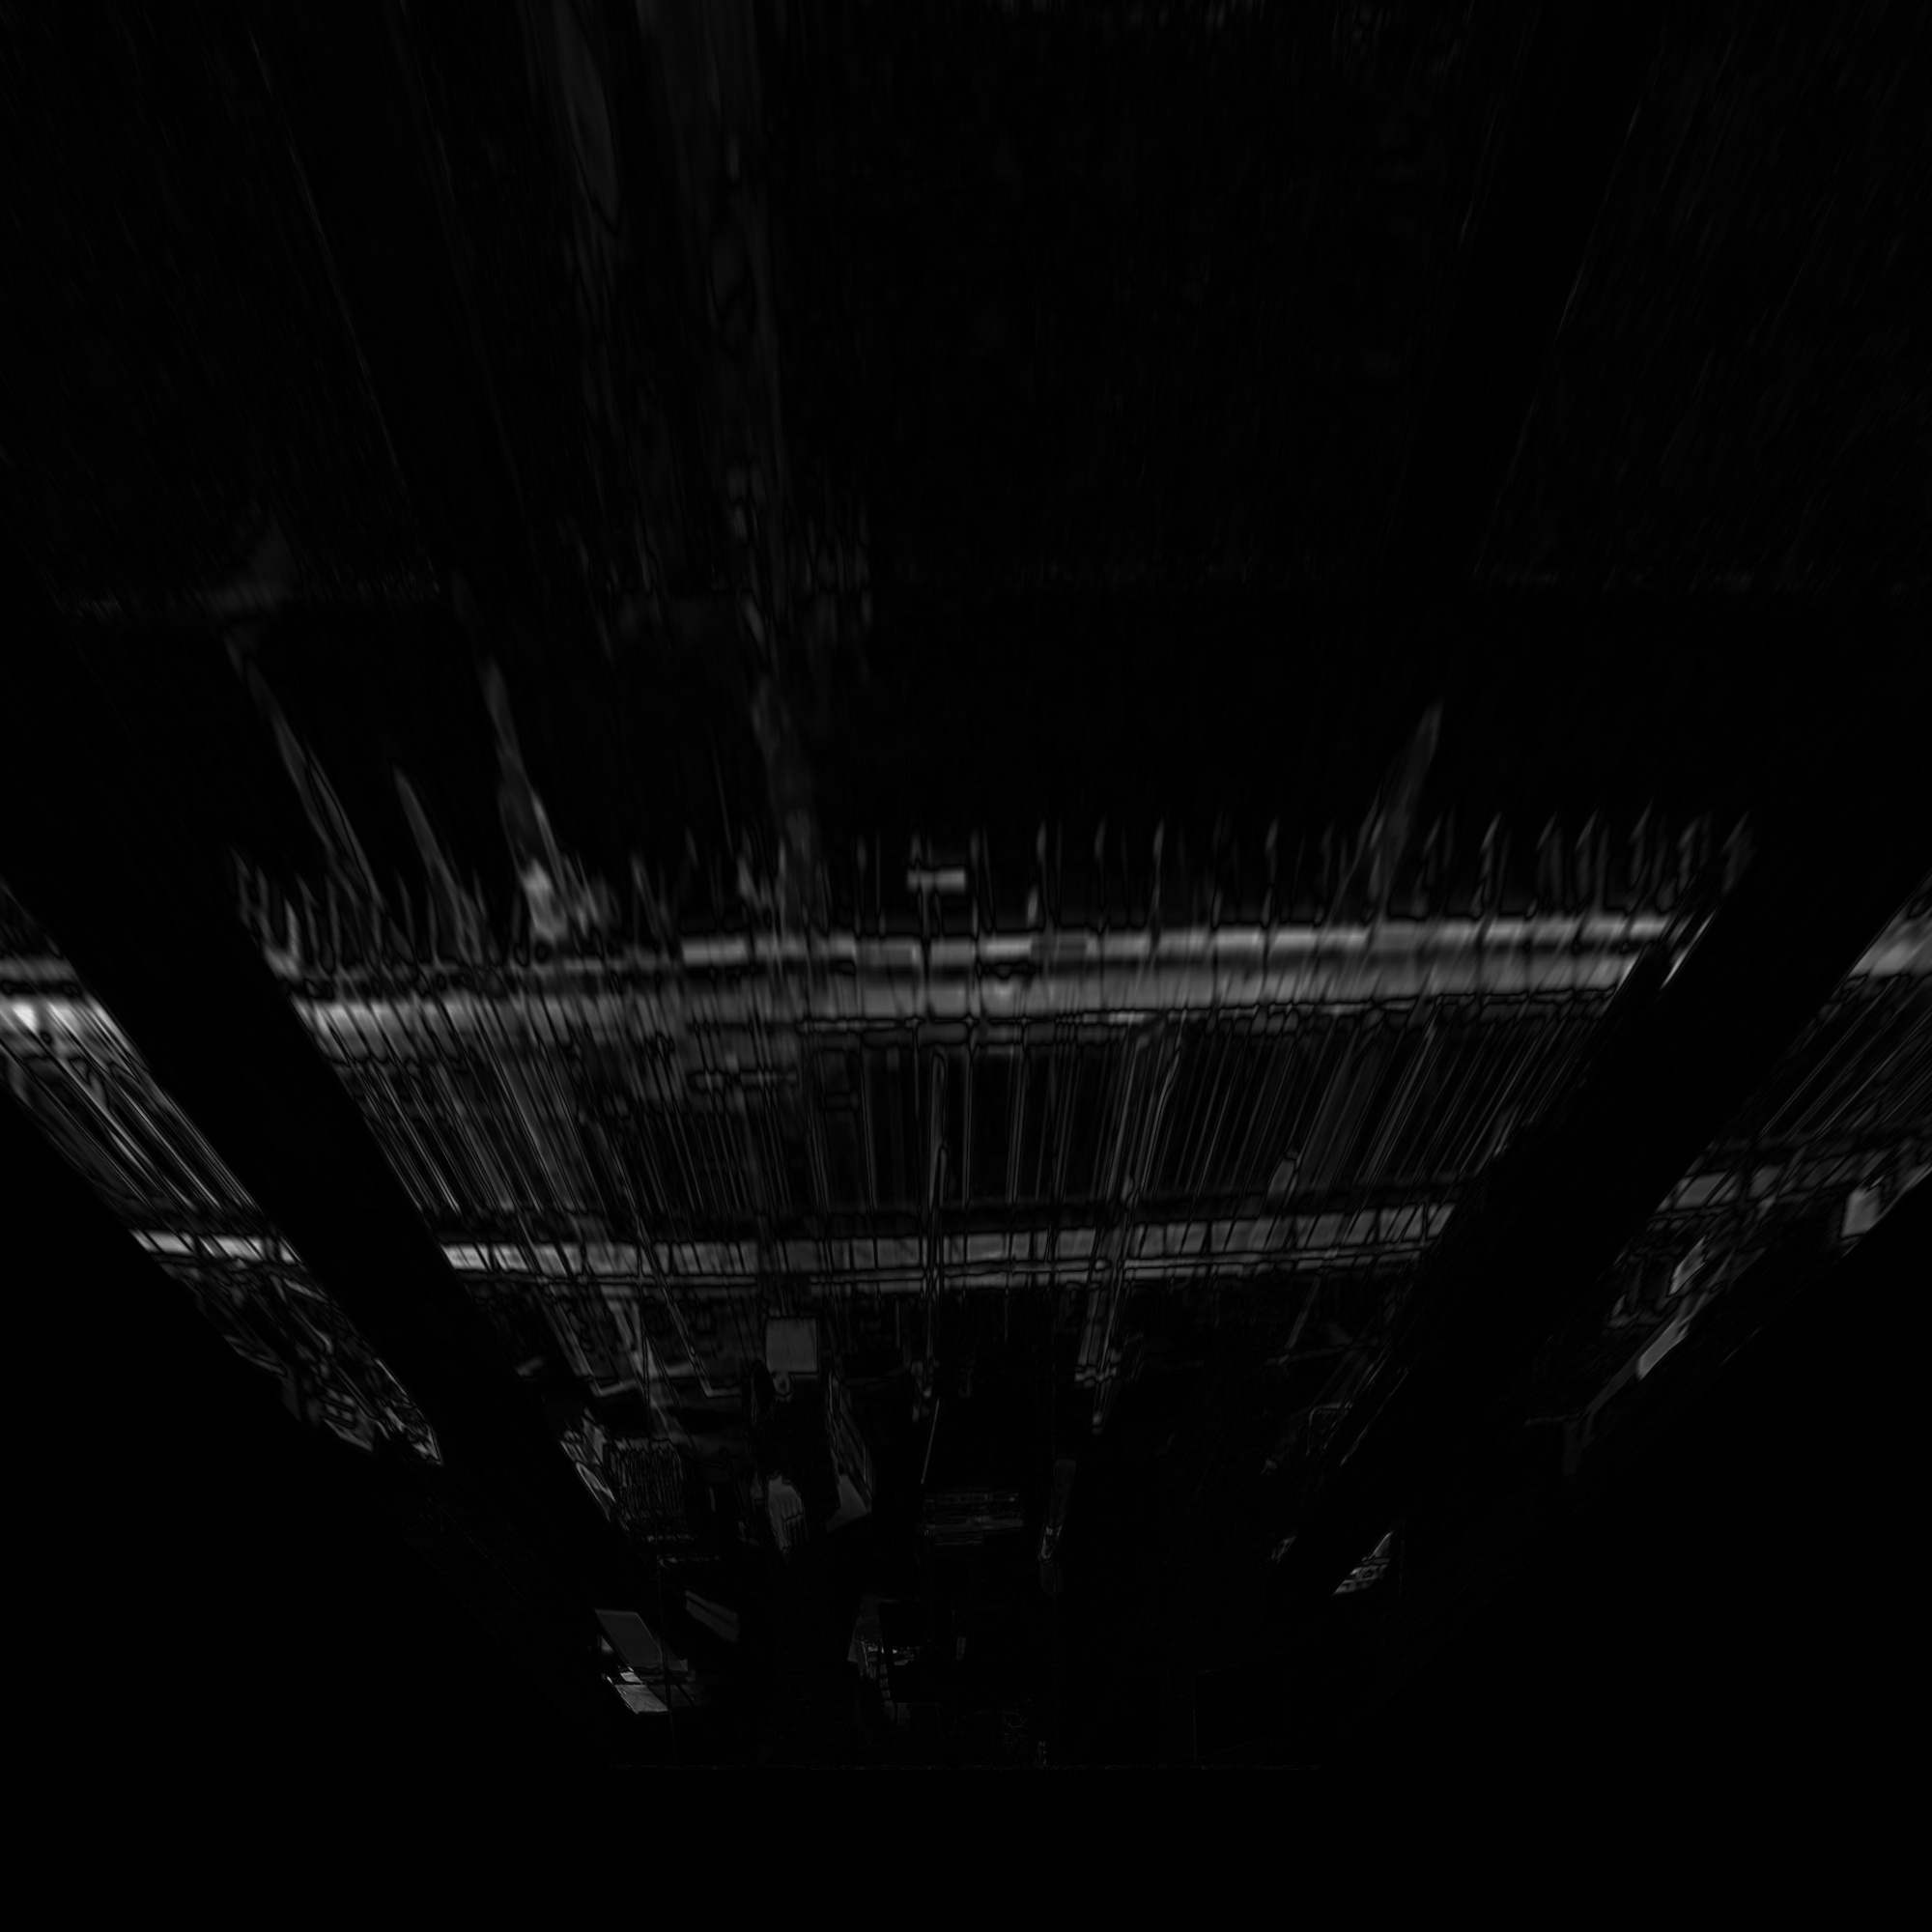

In [41]:
LIME_path = "data/thresholding/diff/3951_lime.jpg"
none_path = "data/thresholding/diff/3951_none.jpg"
gamma_path = "data/thresholding/diff/3951_gamma.jpg"
frame_num = 3884
LIME_df = cv2.imread(LIME_path)
LIME_df = cv2.cvtColor(LIME_df, cv2.COLOR_BGR2GRAY)

none_df = cv2.imread(none_path)
none_df = cv2.cvtColor(none_df, cv2.COLOR_BGR2GRAY)


gamma_df = cv2.imread(gamma_path)
gamma_df = cv2.cvtColor(gamma_df, cv2.COLOR_BGR2GRAY)

show(LIME_df)
show(none_df)
show(gamma_df)


(2000, 2000)


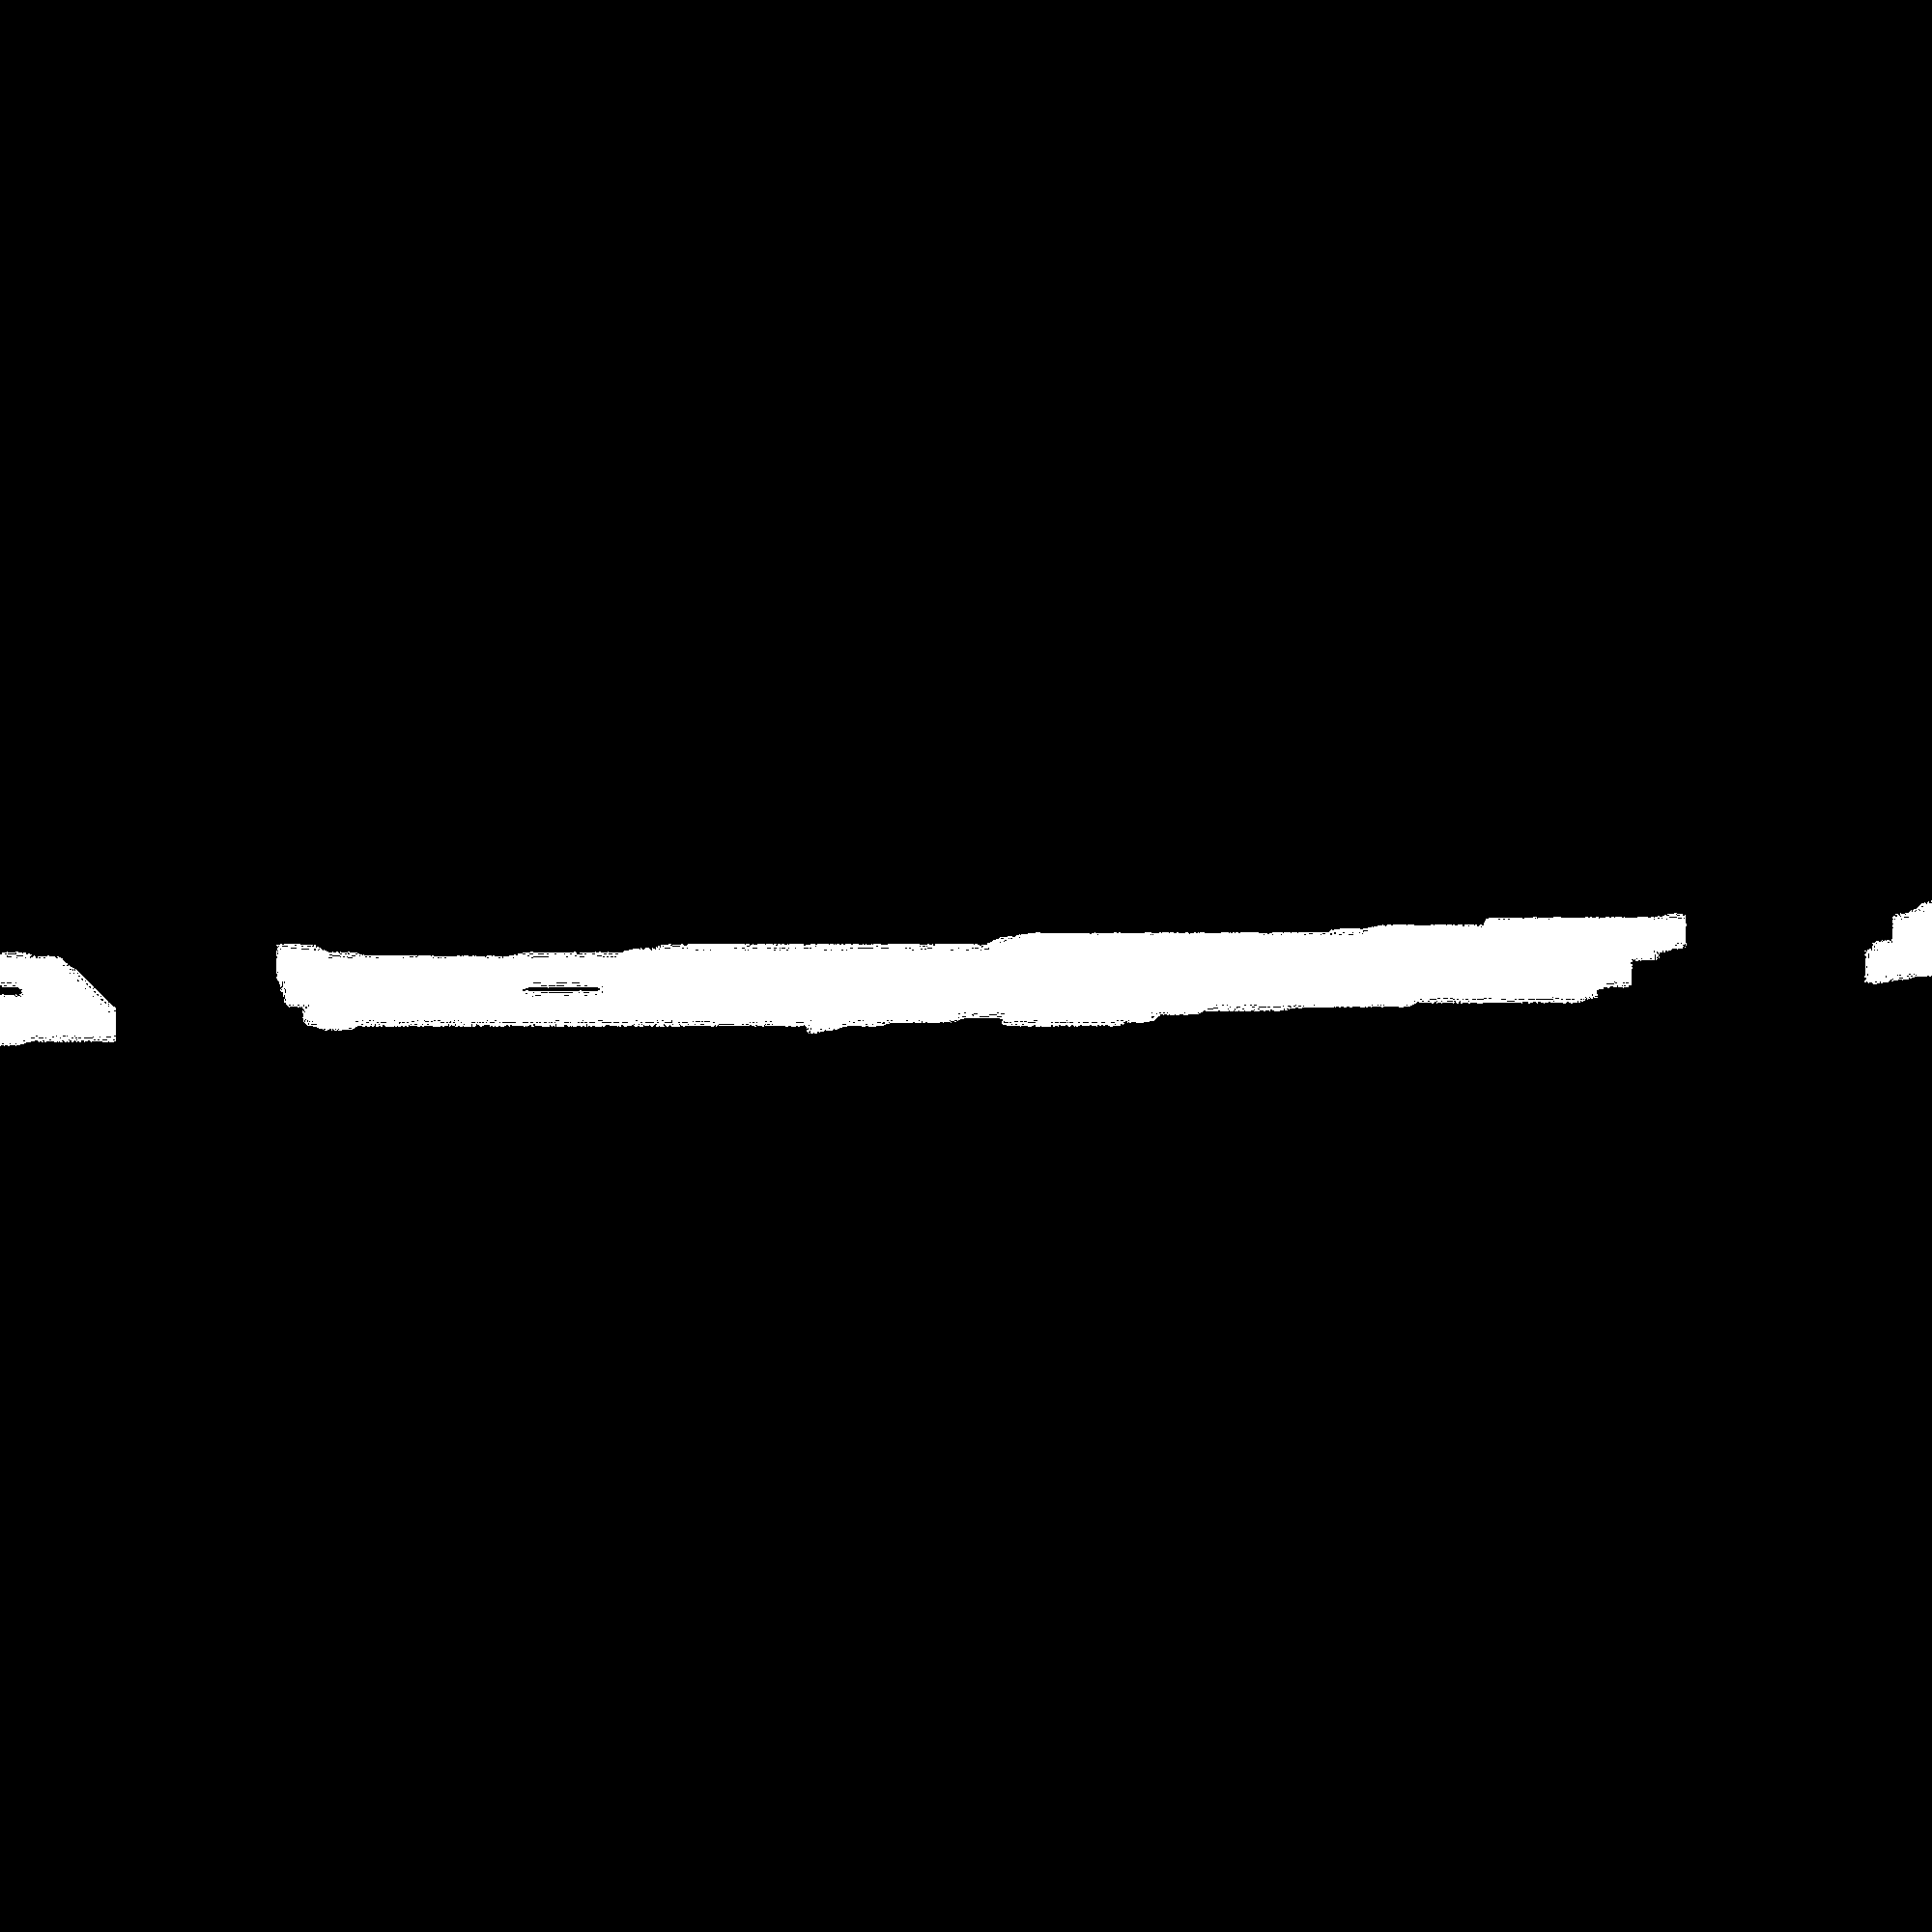

In [43]:
pr_path = "data/thresholding/diff/3951_pr.jpg"
pr = cv2.imread(pr_path)
pr = extract_red(pr)
print(pr.shape)
show(pr)

121


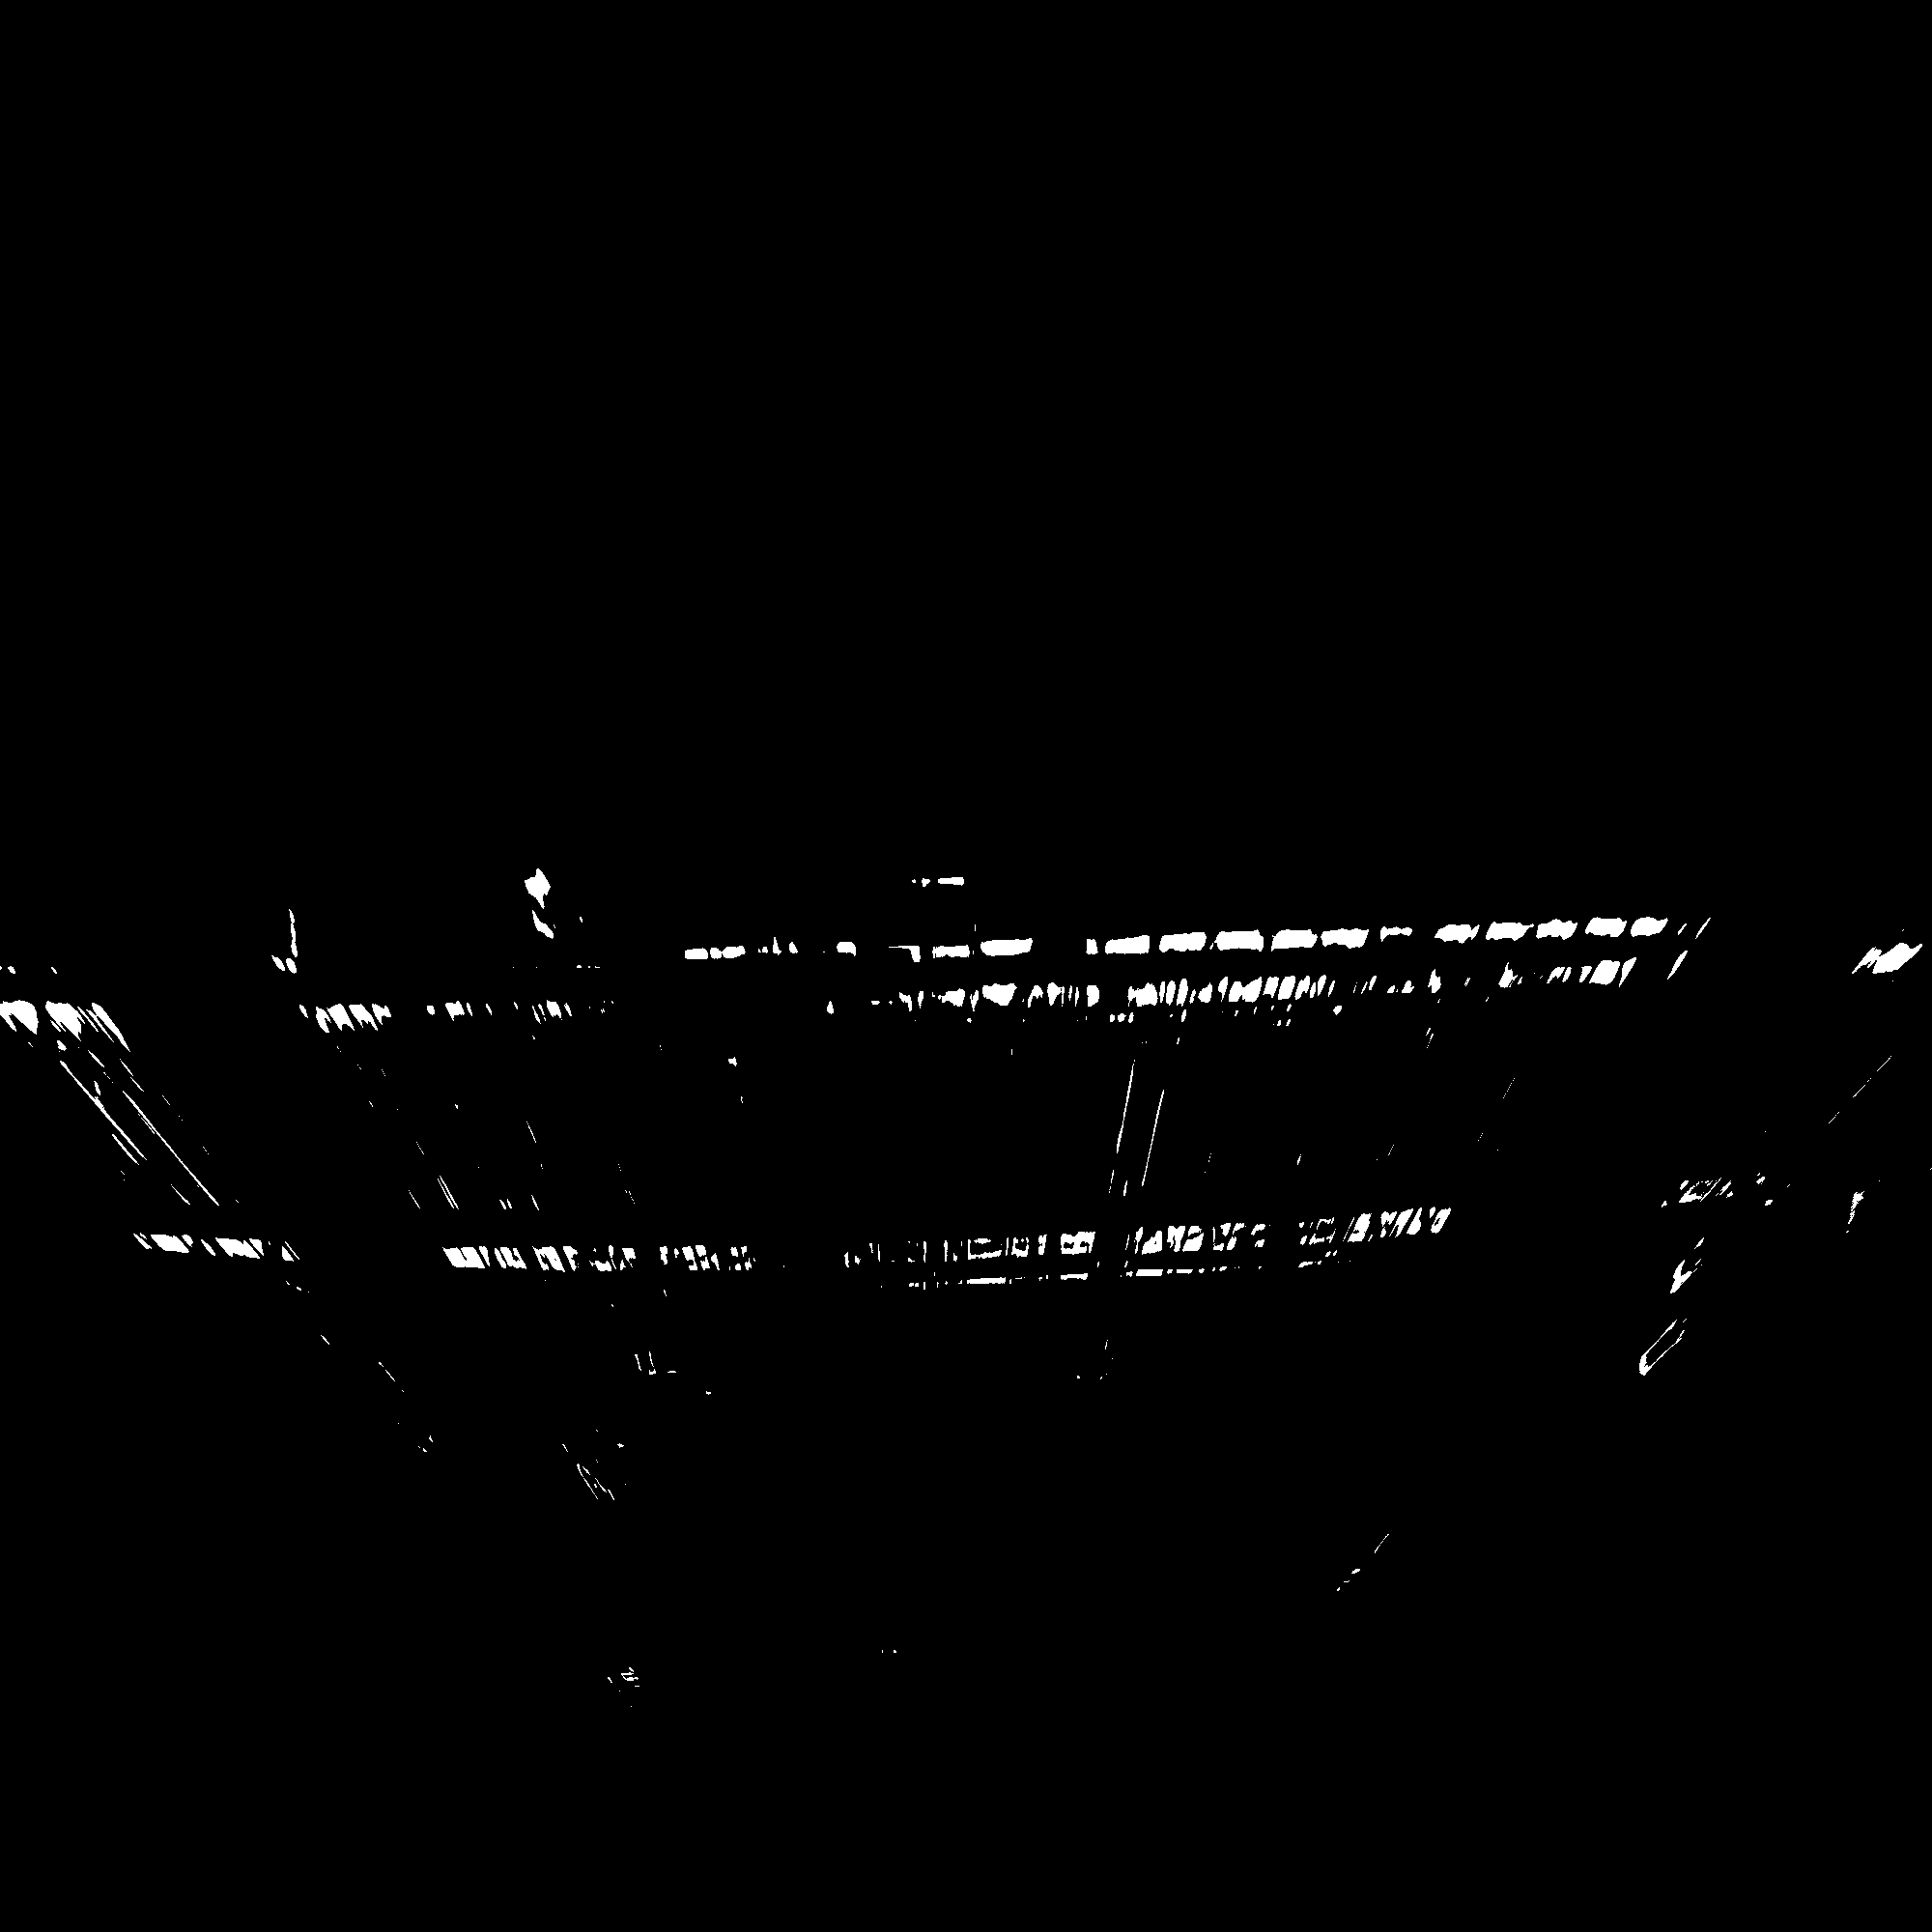

True

In [45]:
date = strftime("%Y-%m-%d %H:%M:%S", gmtime())

thresh, error = find_best_th(LIME_df, pr)
print(thresh)
ret, th_img = cv2.threshold(LIME_df, thresh, 255, cv2.THRESH_BINARY)
show(th_img)
cv2.imwrite('data/thresholding/big_images/LIME_global_thresh'+date+'.jpg', th_img)

47


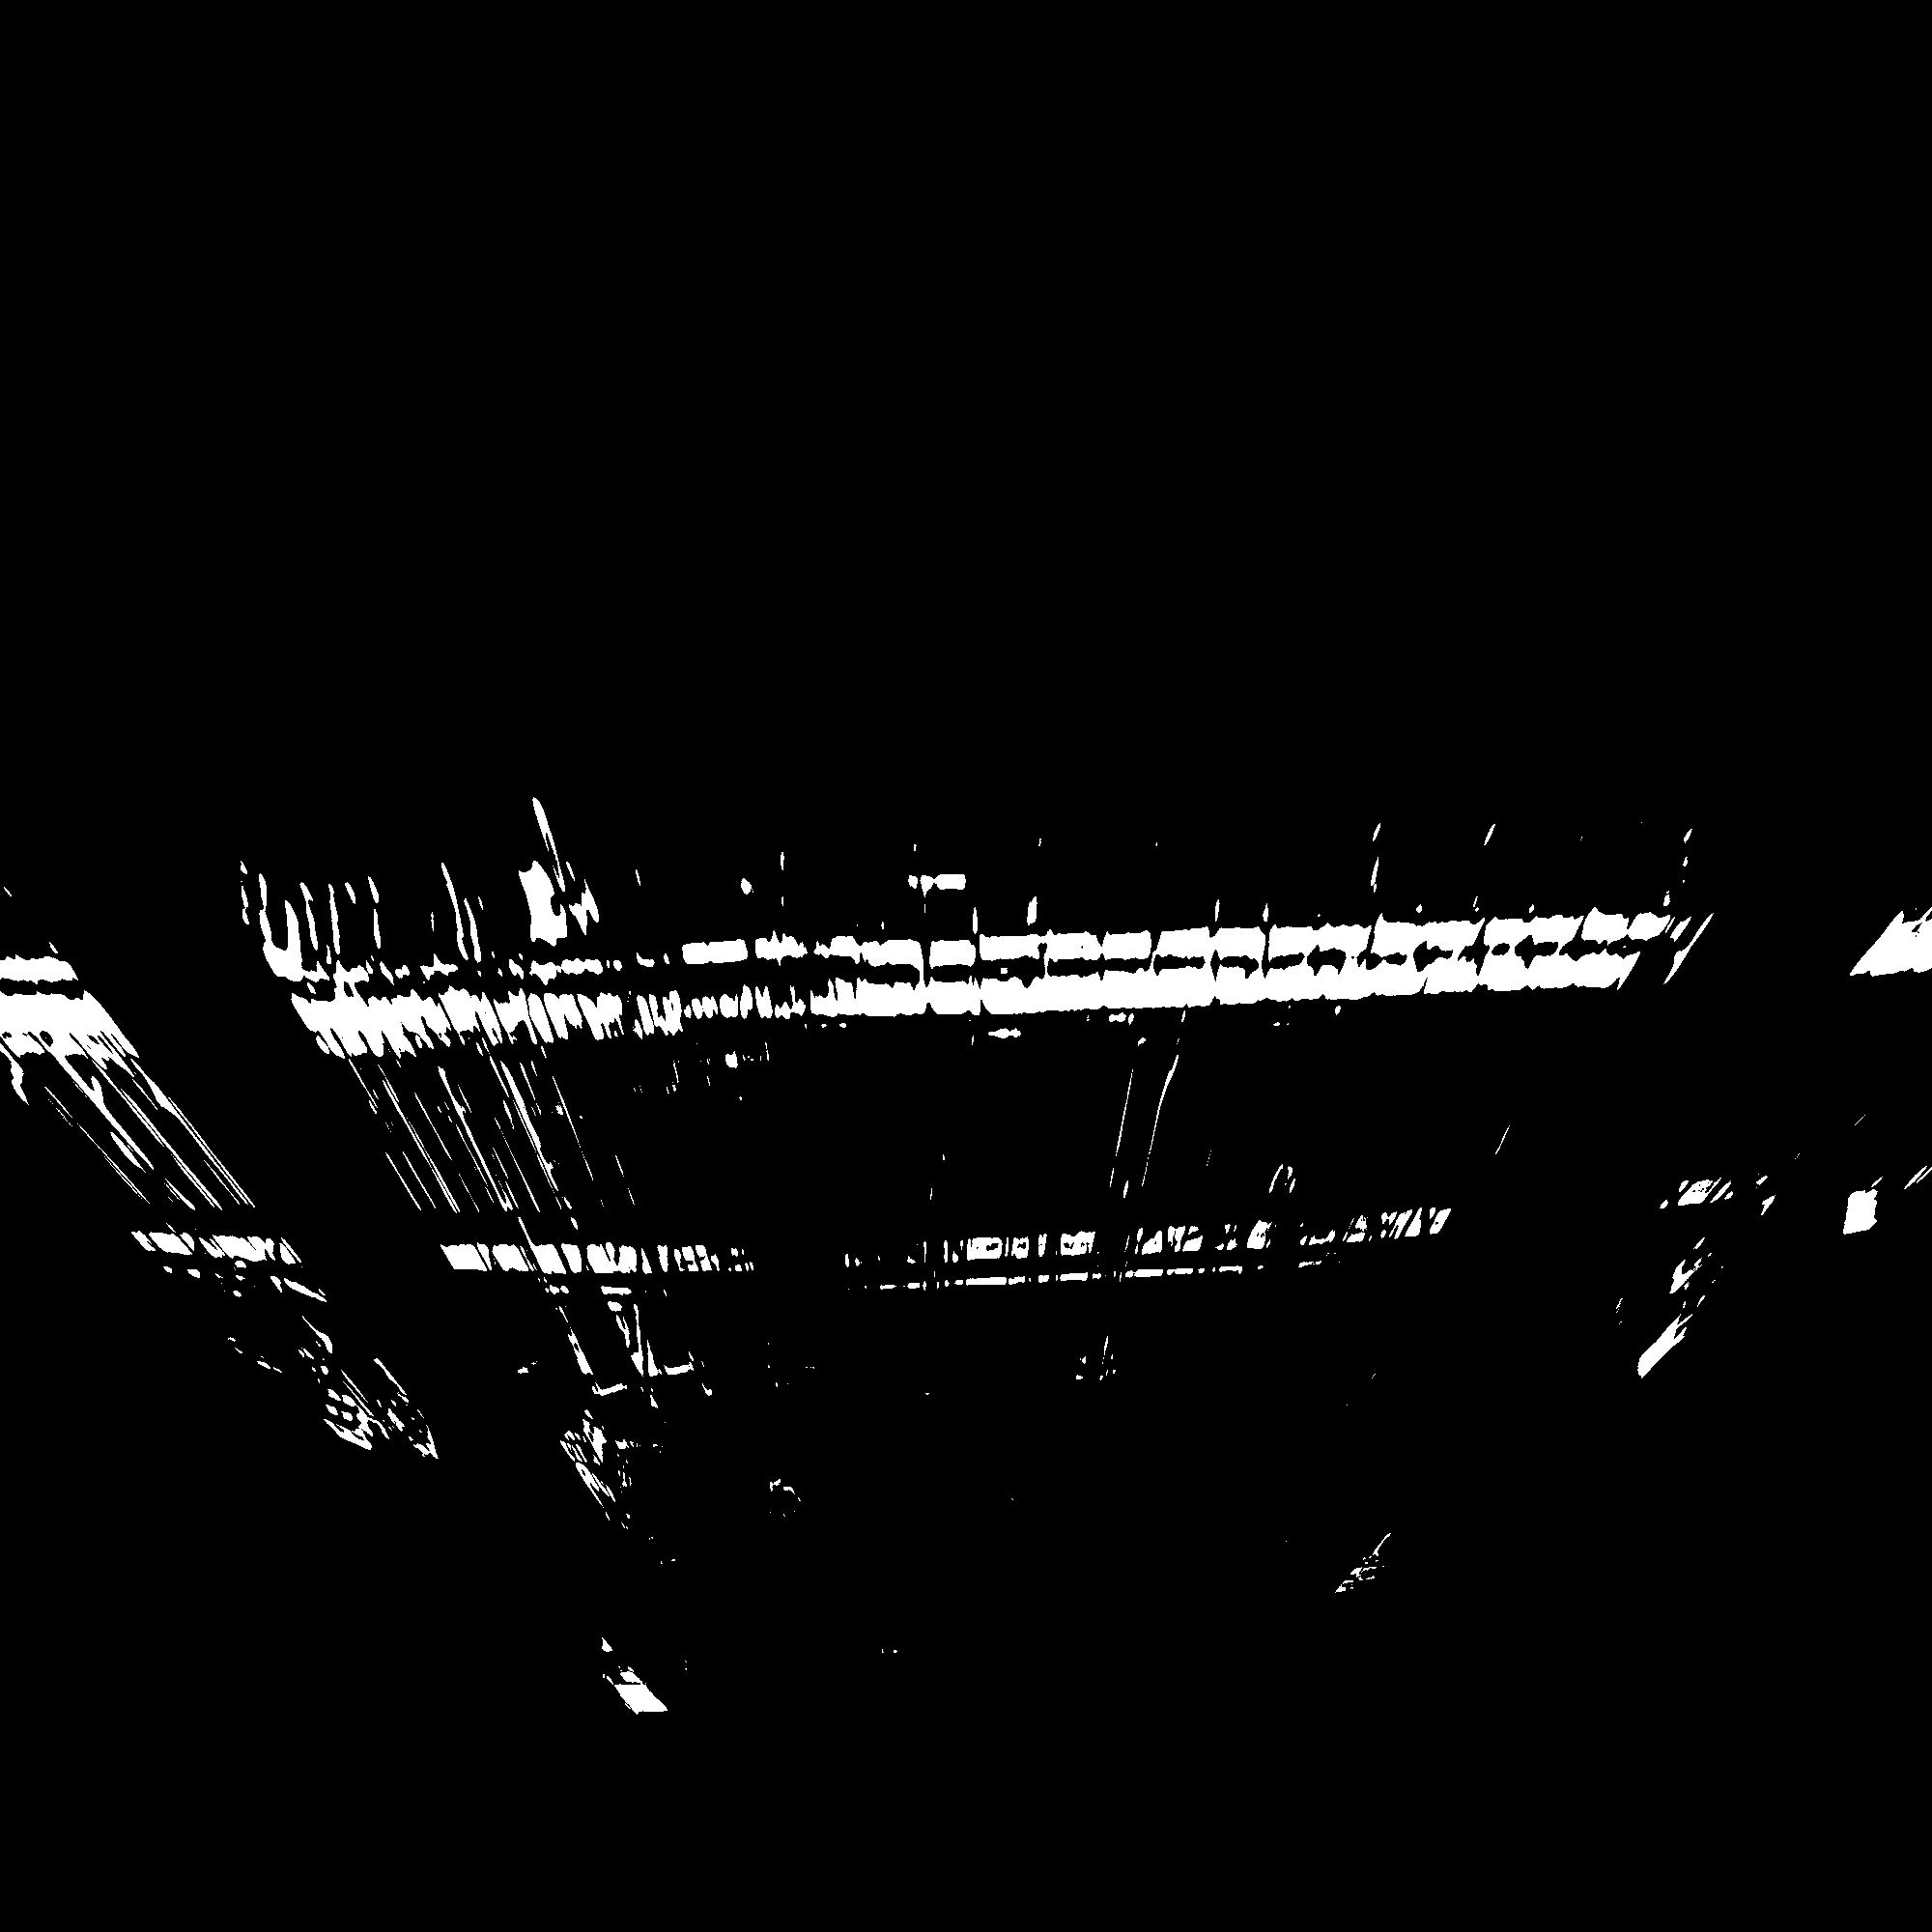

True

In [48]:
thresh, error = find_best_th(none_df, pr)
print(tresh)
ret, th_img = cv2.threshold(none_df, tresh, 255, cv2.THRESH_BINARY)
show(th_img)
cv2.imwrite('data/thresholding/big_images/none_global_thresh'+date+'.jpg', th_img)

47


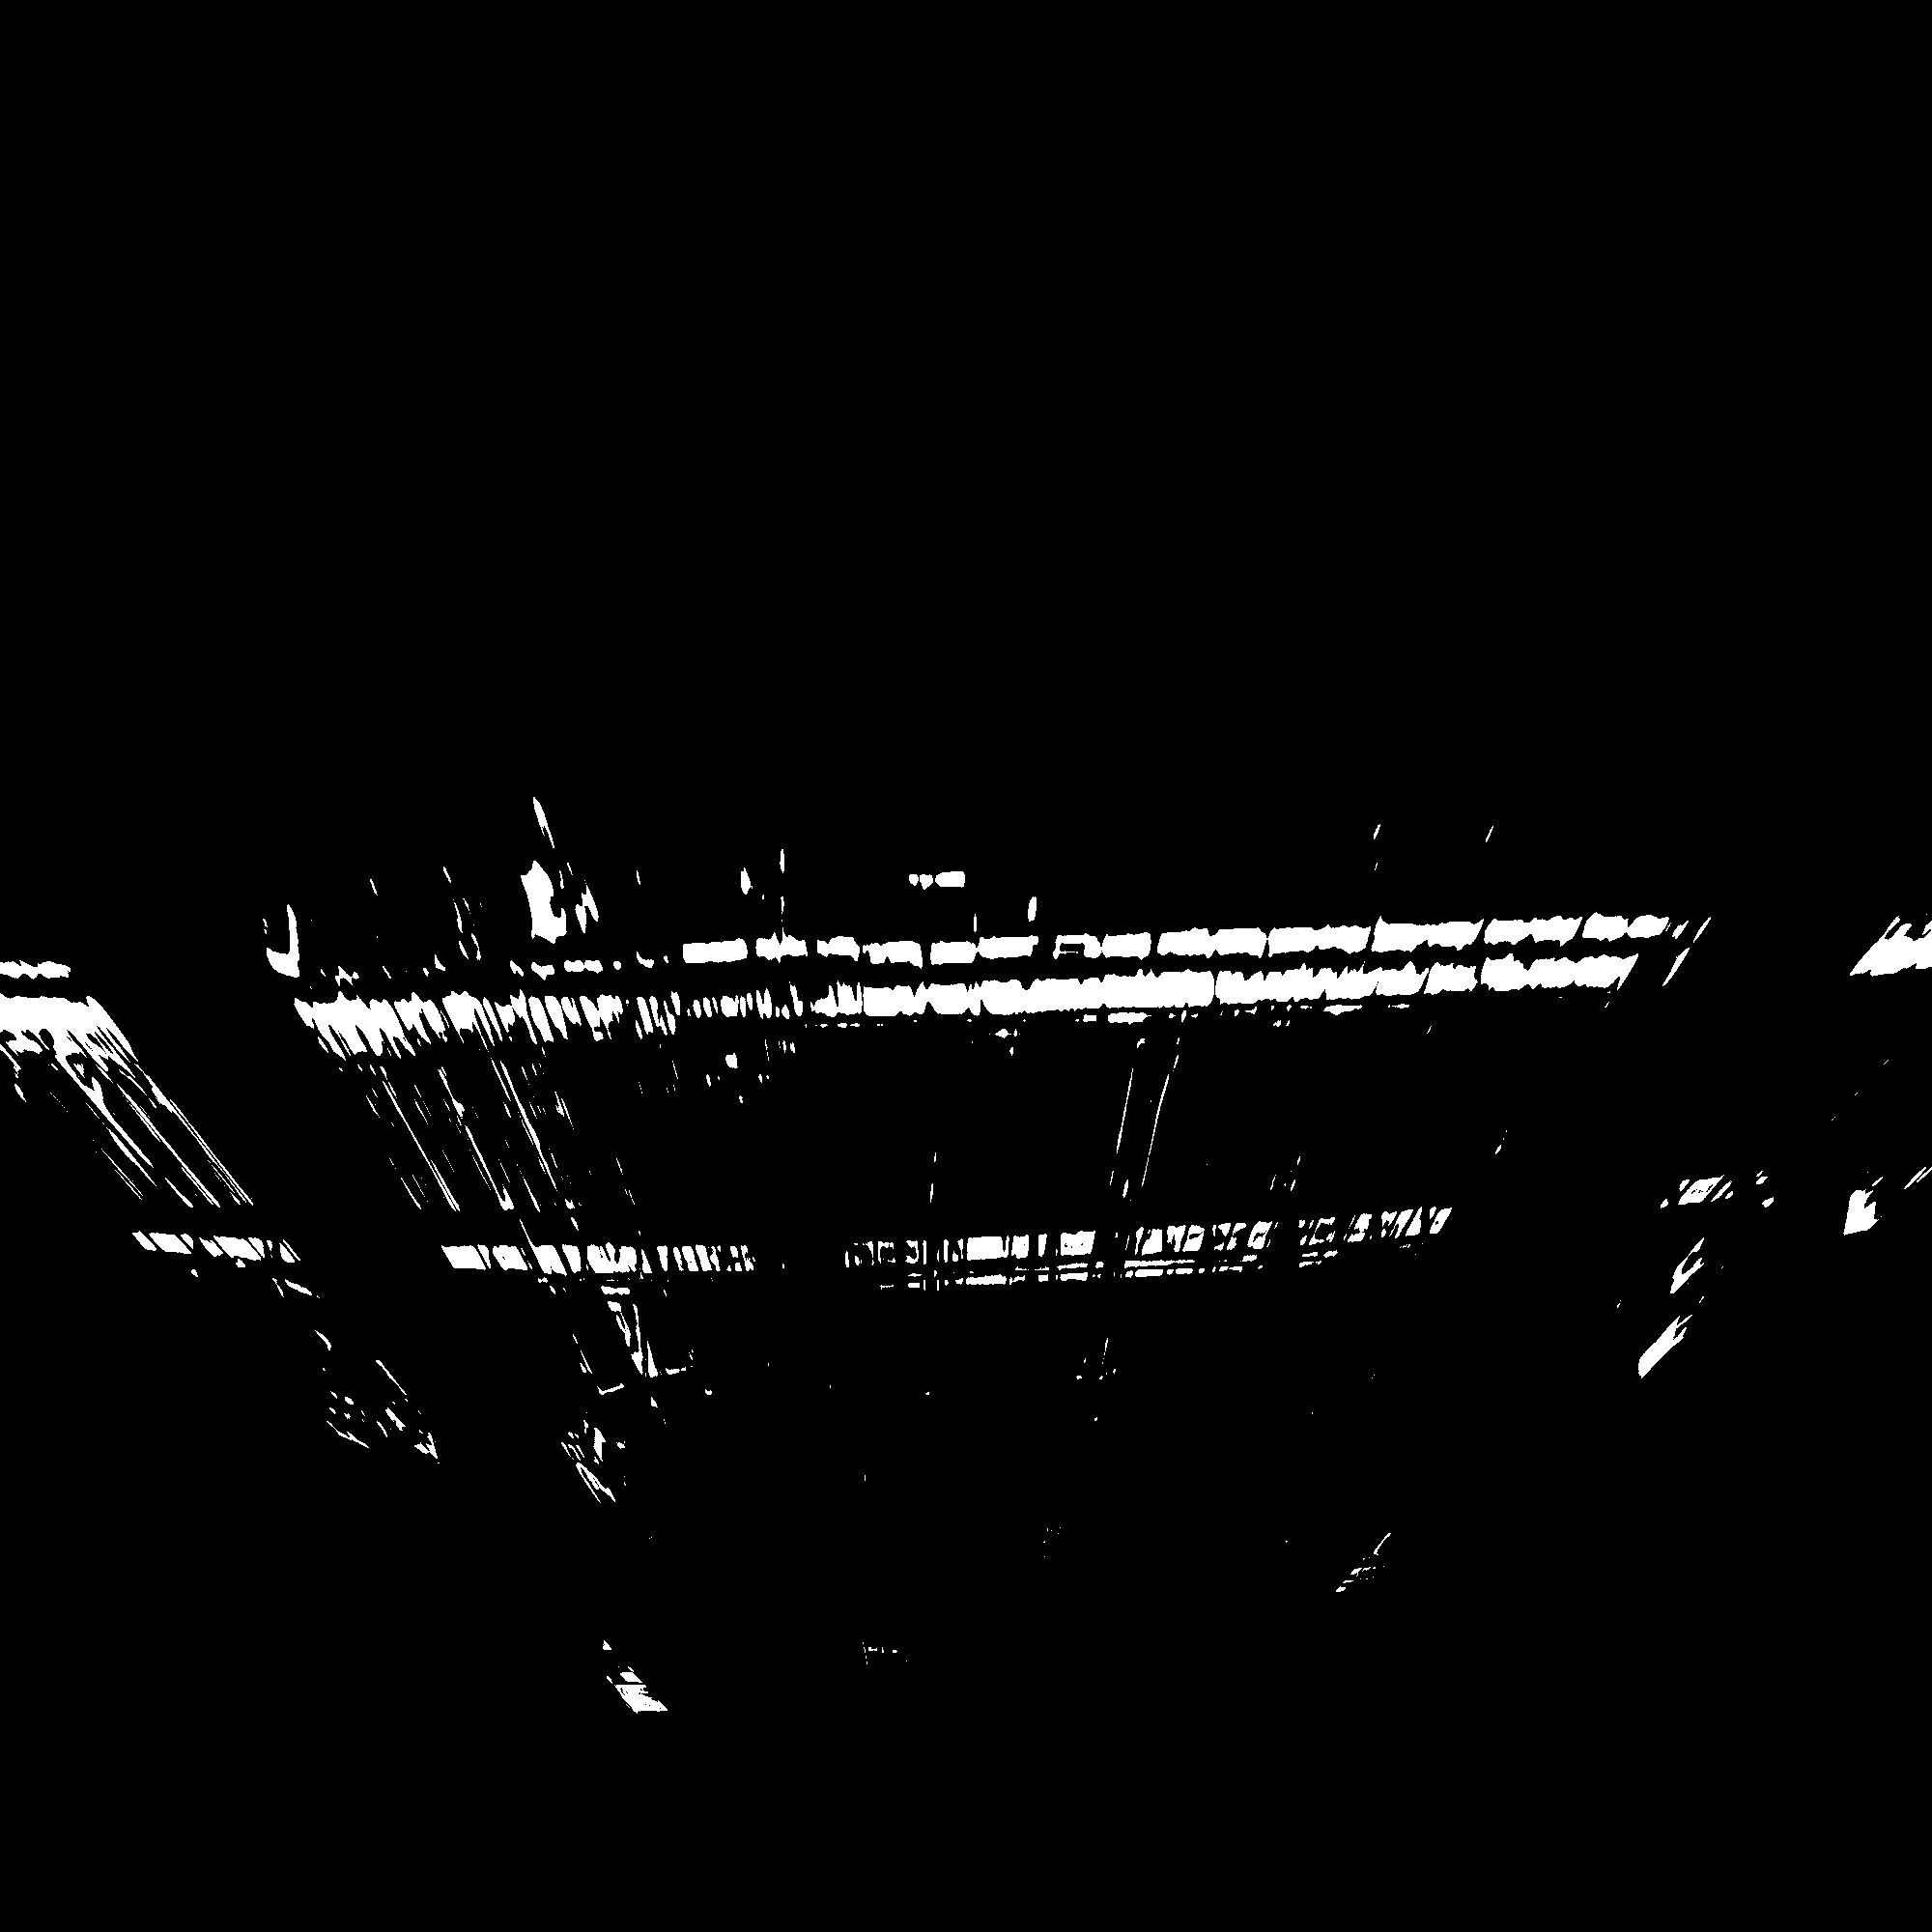

True

In [49]:
thresh, error = find_best_th(gamma_df, pr)
print(tresh)
ret, th_img = cv2.threshold(gamma_df, tresh, 255, cv2.THRESH_BINARY)
show(th_img)
cv2.imwrite('data/thresholding/big_images/gamma_global_thresh'+date+'.jpg', th_img)

# Histograms

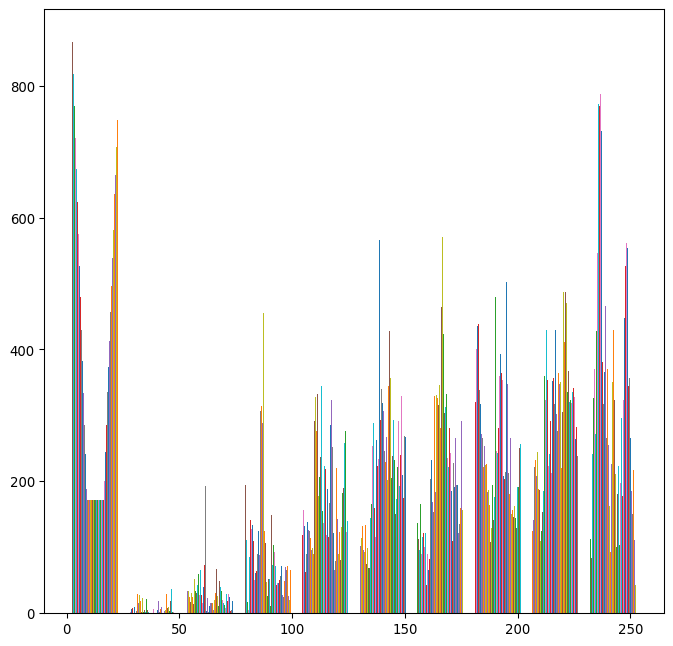

In [55]:
def get_hist(img):
    illuminationImg = np.amax(img, axis=2)
    plt.hist(illuminationImg)
    
LIME_path = "data/thresholding/avg/3884_lime.jpg"
LIME = cv2.imread(LIME_path)
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
get_hist(LIME)
plt.savefig('flow_results/histograms/LIME_illumination_hist.jpg', dpi=my_dpi)
plt.show()

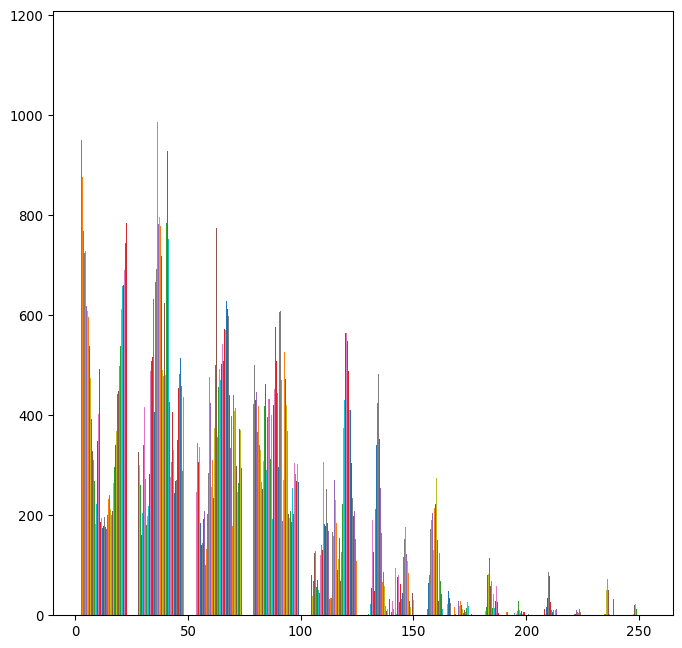

In [56]:
none_path = "data/thresholding/avg/3884_none.jpg"
none = cv2.imread(none_path)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

get_hist(none)
plt.savefig('flow_results/histograms/none_illumination_hist.jpg',  dpi=my_dpi)
plt.show()

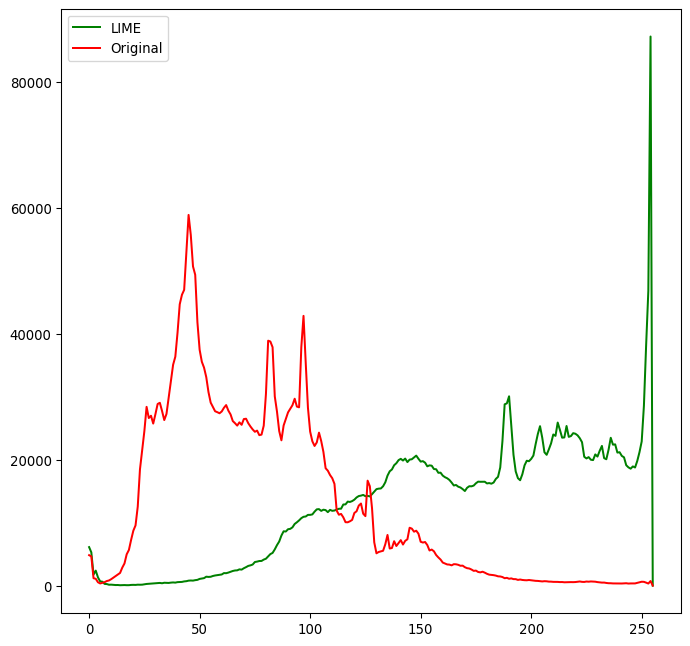

In [57]:
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

illuminationImg = np.amax(LIME, axis=2)
histr_LIME = cv2.calcHist([illuminationImg],[0],None,[256],[1,256])
plt.plot(histr_LIME,color = 'g')


illuminationImg = np.amax(none, axis=2)
histr_LIME = cv2.calcHist([illuminationImg],[0],None,[256],[1,256])
plt.plot(histr_LIME,color = 'r')
plt.legend(['LIME', 'Original'])


plt.savefig('flow_results/histograms/org_vs_LIME.jpg', dpi=my_dpi)
plt.show()


# Adaptive Trehsolding
## Ostu

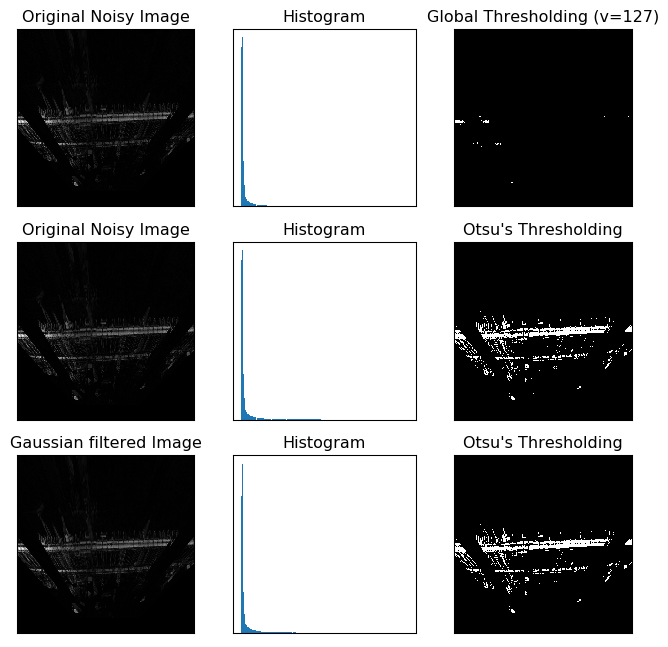

In [58]:
LIME_path = "data/thresholding/diff/3951_lime.jpg"
none_path = "data/thresholding/diff/3951_none.jpg"
gamma_path = "data/thresholding/diff/3951_gamma.jpg"

img = cv2.imread(none_path,0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()